# Exploring MovieLens : Collaborative Filtering
## Adding word embeddings


In [1]:
import pandas as pd
import numpy as np 

from sklearn.cluster import AffinityPropagation, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from scipy import stats
from scipy.spatial.distance import pdist

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from itertools import cycle

import string

import os

from collections import Counter

from tqdm import *

In [2]:
from keras.layers.embeddings import Embedding
from keras.layers import Input, merge
from keras.models import Model
from keras.layers.core import Flatten, Dropout, Dense
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

from keras.regularizers import l1, l2

from keras.layers.recurrent import GRU, LSTM

from keras import backend as K

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


## Importing the data

In [3]:
org_ratings = pd.read_csv('data/MovieLens/ratings.csv')
org_movies = pd.read_csv('data/MovieLens/movies.csv')
org_tags = pd.read_csv('data/MovieLens/tags.csv')
org_ratings.head(), org_movies.head()


(   userId  movieId  rating   timestamp
 0       1       31     2.5  1260759144
 1       1     1029     3.0  1260759179
 2       1     1061     3.0  1260759182
 3       1     1129     2.0  1260759185
 4       1     1172     4.0  1260759205,
    movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  
 0  Adventure|Animation|Children|Comedy|Fantasy  
 1                   Adventure|Children|Fantasy  
 2                               Comedy|Romance  
 3                         Comedy|Drama|Romance  
 4                                       Comedy  )

In [4]:
users = org_ratings.userId.unique()
movies = org_ratings.movieId.unique()
rating = org_ratings.rating.unique()
len(users), len(movies), len(rating)

(671, 9066, 10)

In [5]:
userid2idx = {o:i for i,o in enumerate(users)}
useridx2id = {i:o for i,o in enumerate(users)}

movieid2idx = {o:i for i,o in enumerate(movies)}
movieidx2id = {i:o for i,o in enumerate(movies)}

First, I want to make the movieIds and the userIds continuous

In [6]:
new_ratings = org_ratings.copy()

new_ratings.movieId = org_ratings.movieId.apply(lambda x: movieid2idx[x])
new_ratings.userId = org_ratings.userId.apply(lambda x: userid2idx[x])

In [7]:
new_ratings = new_ratings.drop('timestamp', axis = 1)

In [8]:
new_ratings.head()

,userId,movieId,rating
0,0,0,2.5
1,0,1,3.0
2,0,2,3.0
3,0,3,2.0
4,0,4,4.0


I now want to add one more thing: the tags given by each user to each movie (if one exists)

In [9]:
new_ratings['tags'] = ""
new_ratings.head()

,userId,movieId,rating,tags
0,0,0,2.5,
1,0,1,3.0,
2,0,2,3.0,
3,0,3,2.0,
4,0,4,4.0,


Now, if a user has left a comment for a movie, I want to break down each word (this is appropriate since most of the comments are one or two words) and then use GloVe to get the embeddings for the word. This embedding should contain the sentiment of the word. 

There's some preprocessing to be done; I'm going to run it all in this single loop, so it will take a little to run. I've added a progress bar to track how it's doing. 

In [10]:
new_tags = org_tags.copy()

In [11]:
for i in tqdm(range(len(new_ratings))): 
    old_movie_id = movieidx2id[new_ratings.movieId[i]]
    old_user_id = useridx2id[new_ratings.userId[i]]
    new_tags_idx = []
    
    new_tags_idx = np.where((new_tags.movieId == old_movie_id) & (new_tags.userId == old_user_id))[0]
    if new_tags_idx.size > 0:
        #make a string
        temp_str  = ''
        str_array = []
        for i in range(len(new_tags_idx)): 
            temp_str += new_tags.tag[new_tags_idx[i]] + " "
            
        #removing punctuation, set all letters to lowercase
        temp_str = temp_str.translate(None, string.punctuation).lower()
        str_array = temp_str.split(" ")
        new_ratings.set_value(i, 'tags', str_array)

100%|██████████| 100004/100004 [01:07<00:00, 1474.42it/s]


In [12]:
new_ratings.head()

,userId,movieId,rating,tags
0,0,0,2.5,"[gay, ]"
1,0,1,3.0,"[imaginary, world, characters, story, philosop..."
2,0,2,3.0,"[meaning, of, life, philosophical, scifi, ]"
3,0,3,2.0,"[hijacking, ocean, pirates, suspense, ]"
4,0,4,4.0,"[fashion, new, york, city, nudity, topless, rs..."


## Adding word embeddings 
Specifically, using GloVe, from the Tags used

In [13]:
embeddings_index = {}
f = open('data/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Let's take a look at what a single dictionary entry looks like

In [14]:
dict(sorted(embeddings_index.items()[:1]))

{'biennials': array([  7.53019989e-01,   8.01379979e-01,  -7.38770008e-01,
         -4.98160005e-01,  -1.04830003e+00,  -5.86179972e-01,
         -2.98530012e-01,  -1.42299998e+00,  -2.03960001e-01,
          1.54980004e+00,  -1.24249998e-02,   5.02399981e-01,
         -3.64179999e-01,  -4.30269986e-01,   7.28100002e-01,
         -5.63510001e-01,  -2.22240001e-01,   7.02189982e-01,
          1.08829997e-01,  -5.71190000e-01,  -1.41049996e-01,
         -5.45710027e-01,  -3.61989997e-02,  -2.06680000e-01,
         -7.77369976e-01,   1.19480002e+00,   6.10530004e-02,
         -1.78829998e-01,  -5.05890012e-01,  -5.20990014e-01,
         -1.10479999e+00,   7.11489975e-01,   4.37159985e-01,
         -8.73380005e-01,   5.57649992e-02,   8.47259983e-02,
         -2.53160000e-01,   1.12059999e+00,  -3.65579993e-01,
          6.80499971e-02,  -7.84590025e-04,  -1.02470005e+00,
          7.25030005e-01,   4.67220008e-01,   9.32569981e-01,
          9.60820019e-01,   1.16779998e-01,  -3.62179995e

Now, I'm going to add an additional column, which will contain the embedding matrices for the movies

In [16]:
MAX_WORDS = np.amax([len(x) for x in new_ratings.tags])

In [17]:
MAX_WORDS

19

In [46]:
new_ratings['tags_array'] = ""

In [53]:
np.zeros((MAX_WORDS, 50), dtype = np.float32).shape

(19, 50)

In [47]:
new_ratings.head()

,userId,movieId,rating,tags,tags_array
0,0,0,2.5,"[gay, ]",
1,0,1,3.0,"[imaginary, world, characters, story, philosop...",
2,0,2,3.0,"[meaning, of, life, philosophical, scifi, ]",
3,0,3,2.0,"[hijacking, ocean, pirates, suspense, ]",
4,0,4,4.0,"[fashion, new, york, city, nudity, topless, rs...",


In [79]:
# because Pandas doesn't like having ndarrays in its elements - and this messes up my model - 
# I'm going to make a seperate 3D array for these embeddings
tags_array = []
for i in tqdm(range(len(new_ratings))):
    word_matrix = np.zeros((MAX_WORDS, 50), dtype = np.float32)
    words = new_ratings.tags[i]
    for z in range(len(words)):
        if words[z] in embeddings_index:
            word_matrix[z] = np.asarray(embeddings_index[words[z]])
    tags_array.append(word_matrix)
tags_array = np.asarray(tags_array)


 43%|████▎     | 43034/100004 [00:01<00:01, 43183.78it/s]

100%|██████████| 100004/100004 [00:02<00:00, 43004.54it/s]

In [80]:
tags_array.shape

(100004, 19, 50)

Now that I have a new array, tags_array, which has all the word embeddings, I can use this as input to my neural network! Adding this as input to the 'wide' part of my neural net will make it a true 'deep and wide' neural net, instead of what it is currently (which is closer to a 'deep and shallow' net). 

## Finally, preparing the train and validation sets

In [82]:
msk = np.random.rand(len(new_ratings)) < 0.8

train = new_ratings[msk]
valid = new_ratings[~msk]

train_tags_array = tags_array[msk]
valid_tags_array = tags_array[~msk]

In [83]:
print(train.shape, valid.shape, train_tags_array.shape, valid_tags_array.shape)
print(train.head())

((79912, 5), (20092, 5), (79912, 19, 50), (20092, 19, 50))
   userId  movieId  rating                                               tags  \
0       0        0     2.5                                            [gay, ]   
1       0        1     3.0  [imaginary, world, characters, story, philosop...   
2       0        2     3.0        [meaning, of, life, philosophical, scifi, ]   
3       0        3     2.0            [hijacking, ocean, pirates, suspense, ]   
5       0        5     2.0  [funny, jack, black, music, not, only, for, ki...   

                                          tags_array  
0  [[-0.48266, 0.70319, -0.87568, -0.41409, 0.295...  
1  [[0.65537, 0.38191, -0.29002, 0.19434, 1.1022,...  
2  [[0.20642, 0.76389, -0.41878, -0.45034, 0.9656...  
3  [[1.3278, -0.52208, -0.2149, 0.46184, -0.19956...  
5  [[-0.014547, -0.20208, -0.75278, -0.20272, 0.7...  


## Training a wide an deep neural net 

In [119]:
# Multi layer LSTM model

user_input = Input(shape=(1,), dtype='float32', name='user_input')
movie_input = Input(shape = (1,), dtype = 'float32', name = 'movie_input')
tags_input = Input(shape = (19,50,), dtype = 'float32', name = 'tags_input')

#The 'deep' part of the neural net
user_embed = Embedding(len(users), 55, input_length =1, W_regularizer = l2(1e4))(user_input)
movie_embed = Embedding(len(movies), 55, input_length =1, W_regularizer = l2(1e4))(movie_input)
x = merge([user_embed, movie_embed], mode='concat')

x = Dropout(0.8)(x)
BatchNormalization()
x = LSTM(40)(x)
x = Dropout(0.8)(x)
BatchNormalization()

#The 'wide' part of the neural net 


y = Flatten()(tags_input)
BatchNormalization()

final = merge([x, y], mode = 'concat', name = 'final_merge')
BatchNormalization()

preds = Dense(1)(final)

deepwide_nn = Model([tags_input, user_input, movie_input], preds)
deepwide_nn.compile(Adam(0.0001), loss='mse')

In [120]:
deepwide_hist = deepwide_nn.fit([train_tags_array, train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=10, 
          validation_data=([valid_tags_array, valid.userId, valid.movieId], valid.rating))

Train on 79912 samples, validate on 20092 samples
Epoch 1/10
79912/79912 [==============================] - 15s - loss: 538991.3876 - val_loss: 31.7670
Epoch 2/10
79912/79912 [==============================] - 15s - loss: 8.6528 - val_loss: 4.6827
Epoch 3/10
79912/79912 [==============================] - 15s - loss: 3.3091 - val_loss: 1.7056
Epoch 4/10
79912/79912 [==============================] - 15s - loss: 2.1255 - val_loss: 1.2213
Epoch 5/10
79912/79912 [==============================] - 15s - loss: 2.0461 - val_loss: 1.1861
Epoch 6/10
79912/79912 [==============================] - 15s - loss: 2.0026 - val_loss: 1.1819
Epoch 7/10
79912/79912 [==============================] - 15s - loss: 1.9695 - val_loss: 1.1814
Epoch 8/10
79912/79912 [==============================] - 15s - loss: 1.9154 - val_loss: 1.1762
Epoch 9/10
79912/79912 [==============================] - 15s - loss: 1.8596 - val_loss: 1.1730
Epoch 10/10
79912/79912 [==============================] - 15s - loss: 1.8220 - 

In [121]:
deepwide_nn.compile(Adam(0.00005), loss='mse')

In [122]:
deepwide_hist2 = deepwide_nn.fit([train_tags_array, train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=10, 
          validation_data=([valid_tags_array, valid.userId, valid.movieId], valid.rating))

Train on 79912 samples, validate on 20092 samples
Epoch 1/10
79912/79912 [==============================] - 15s - loss: 1.8269 - val_loss: 1.2023
Epoch 2/10
79912/79912 [==============================] - 15s - loss: 1.7901 - val_loss: 1.1884
Epoch 3/10
79912/79912 [==============================] - 15s - loss: 1.7509 - val_loss: 1.1827
Epoch 4/10
79912/79912 [==============================] - 15s - loss: 1.7332 - val_loss: 1.1783
Epoch 5/10
79912/79912 [==============================] - 15s - loss: 1.7079 - val_loss: 1.1706
Epoch 6/10
79912/79912 [==============================] - 15s - loss: 1.6848 - val_loss: 1.1685
Epoch 7/10
79912/79912 [==============================] - 15s - loss: 1.6581 - val_loss: 1.1672
Epoch 8/10
79912/79912 [==============================] - 15s - loss: 1.6320 - val_loss: 1.1641
Epoch 9/10
79912/79912 [==============================] - 15s - loss: 1.6182 - val_loss: 1.1640
Epoch 10/10
79912/79912 [==============================] - 15s - loss: 1.5973 - val_lo

In [125]:
deepwide_nn.compile(Adam(0.00001), loss='mse')

In [128]:
deepwide_hist3 = deepwide_nn.fit([train_tags_array, train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=10, 
          validation_data=([valid_tags_array, valid.userId, valid.movieId], valid.rating))

Train on 79912 samples, validate on 20092 samples
Epoch 1/10
79912/79912 [==============================] - 16s - loss: 1.5658 - val_loss: 1.1452
Epoch 2/10
79912/79912 [==============================] - 15s - loss: 1.5623 - val_loss: 1.1453
Epoch 3/10
79912/79912 [==============================] - 15s - loss: 1.5595 - val_loss: 1.1447
Epoch 4/10
79912/79912 [==============================] - 15s - loss: 1.5480 - val_loss: 1.1447
Epoch 5/10
79912/79912 [==============================] - 15s - loss: 1.5425 - val_loss: 1.1439
Epoch 6/10
79912/79912 [==============================] - 15s - loss: 1.5533 - val_loss: 1.1440
Epoch 7/10
79912/79912 [==============================] - 15s - loss: 1.5382 - val_loss: 1.1433
Epoch 8/10
79912/79912 [==============================] - 15s - loss: 1.5470 - val_loss: 1.1437
Epoch 9/10
79912/79912 [==============================] - 15s - loss: 1.5303 - val_loss: 1.1427
Epoch 10/10
79912/79912 [==============================] - 15s - loss: 1.5381 - val_lo

In [129]:
deepwide_nn.compile(Adam(0.000005), loss='mse')

In [130]:
deepwide_hist4 = deepwide_nn.fit([train_tags_array, train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=10, 
          validation_data=([valid_tags_array, valid.userId, valid.movieId], valid.rating))

Train on 79912 samples, validate on 20092 samples
Epoch 1/10
79912/79912 [==============================] - 15s - loss: 1.5368 - val_loss: 1.1421
Epoch 2/10
79912/79912 [==============================] - 15s - loss: 1.5243 - val_loss: 1.1420
Epoch 3/10
79912/79912 [==============================] - 15s - loss: 1.5165 - val_loss: 1.1417
Epoch 4/10
79912/79912 [==============================] - 15s - loss: 1.5360 - val_loss: 1.1416
Epoch 5/10
79912/79912 [==============================] - 15s - loss: 1.5234 - val_loss: 1.1417
Epoch 6/10
79912/79912 [==============================] - 15s - loss: 1.5163 - val_loss: 1.1414
Epoch 7/10
79912/79912 [==============================] - 15s - loss: 1.5171 - val_loss: 1.1412
Epoch 8/10
79912/79912 [==============================] - 15s - loss: 1.5207 - val_loss: 1.1410
Epoch 9/10
79912/79912 [==============================] - 15s - loss: 1.5132 - val_loss: 1.1407
Epoch 10/10
79912/79912 [==============================] - 15s - loss: 1.5217 - val_lo

In [131]:
deepwide_nn.compile(Adam(0.000001), loss='mse')

In [132]:
deepwide_hist5 = deepwide_nn.fit([train_tags_array, train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=10, 
          validation_data=([valid_tags_array, valid.userId, valid.movieId], valid.rating))

Train on 79912 samples, validate on 20092 samples
Epoch 1/10
79912/79912 [==============================] - 15s - loss: 1.5258 - val_loss: 1.1402
Epoch 2/10
79912/79912 [==============================] - 15s - loss: 1.5175 - val_loss: 1.1402
Epoch 3/10
79912/79912 [==============================] - 15s - loss: 1.5056 - val_loss: 1.1401
Epoch 4/10
79912/79912 [==============================] - 15s - loss: 1.5142 - val_loss: 1.1401
Epoch 5/10
79912/79912 [==============================] - 15s - loss: 1.5152 - val_loss: 1.1401
Epoch 6/10
79912/79912 [==============================] - 15s - loss: 1.5096 - val_loss: 1.1401
Epoch 7/10
79912/79912 [==============================] - 15s - loss: 1.5158 - val_loss: 1.1401
Epoch 8/10
79912/79912 [==============================] - 15s - loss: 1.5134 - val_loss: 1.1401
Epoch 9/10
79912/79912 [==============================] - 15s - loss: 1.5155 - val_loss: 1.1401
Epoch 10/10
79912/79912 [==============================] - 15s - loss: 1.5097 - val_lo

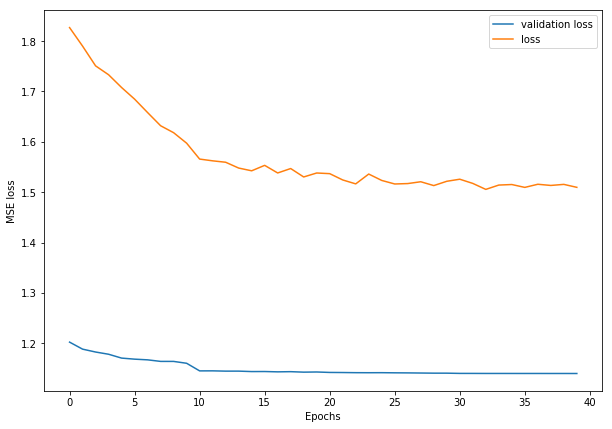

In [133]:
val_loss = deepwide_hist2.history['val_loss'] + deepwide_hist3.history['val_loss'] + deepwide_hist4.history['val_loss'] + deepwide_hist5.history['val_loss']  

loss = deepwide_hist2.history['loss'] + deepwide_hist3.history['loss'] + deepwide_hist4.history['loss'] + deepwide_hist5.history['loss']    
    
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(val_loss, label = 'validation loss')
plt.plot(loss, label = 'loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.show()